In [29]:
%%time
import cv2
import numpy as np
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import noise
from colorsys import *
import math
import random

from mesh import Mesh


%matplotlib inline
%config InlineBackend.figure_format = 'png'

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 20

MAP_SIZE = 2048
DOTS_DENSITY = 0.017

DOTS_AMOUNT = int(MAP_SIZE * MAP_SIZE * DOTS_DENSITY)
TECTONIC_PLATES_AMOUNT = 16
    
print("DOTS_AMOUNT =", DOTS_AMOUNT)


def shimg(img, name):
    cv2.imwrite(f"img_out/{name}.png", cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    plt.imshow(img)
    plt.show()

DOTS_AMOUNT = 71303
Wall time: 15 ms


In [30]:
%%time

print("Generating mesh", flush=True)
mesh = Mesh(dimensions=(MAP_SIZE, MAP_SIZE), npoints=DOTS_AMOUNT, relax_steps=2)

print("Allocating image", flush=True)
img = np.zeros((MAP_SIZE, MAP_SIZE, 3), np.uint8)

print("Drawing image", flush=True)
for i in range(len(mesh.ridge_vertices)):
    if mesh.ridge_vertices[i][0] < 0:
        continue
    coordinates = mesh.vertices[mesh.ridge_vertices[i]]
    cv2.line(img, tuple(coordinates[0].astype(int)), tuple(coordinates[1].astype(int)), (153, 0, 0), 1)

shimg(img, "mesh")

Generating mesh


Allocating image


Drawing image


Drawing background


Generating plates


Drawing plates


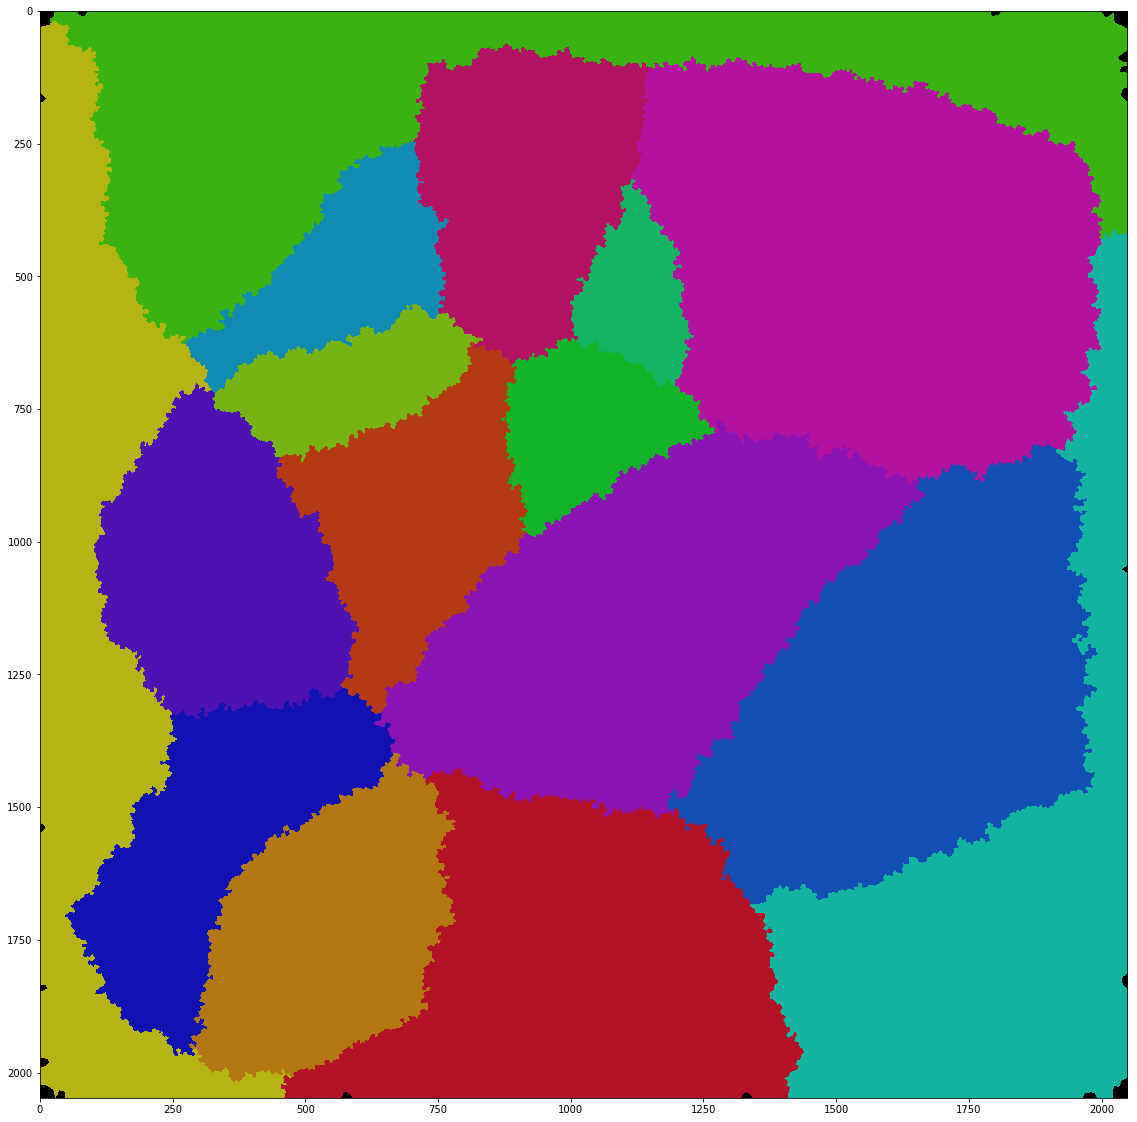

Wall time: 3.23 s


In [45]:
%%time

img = np.zeros((MAP_SIZE, MAP_SIZE, 3), np.uint8)
mesh.create_noise()


def create_tectonic_plates(mesh: Mesh, n: int):
    spread_p = np.random.uniform(0.3, 0.7, n)
    plates = [{p} for p in random.sample(range(len(mesh.points)), n)]
    taken = {p for point_set in plates for p in point_set}

    active_set = {n for region in plates for r in region for n in list(mesh.neighbor_points[r])} - mesh.infinite_regions
    while active_set:
        to_remove = set()
        to_add = set()
        for region in active_set:
            if mesh.point_region[region] in mesh.infinite_regions:
                to_remove.add(region)
                continue
            neighbors = mesh.neighbor_points[region]
            candidates = neighbors & taken
            join_to = random.sample(candidates, 1)[0]
            pl, pi = next((p, i) for i, p in enumerate(plates) if join_to in p)
            if random.random() > spread_p[pi]:
                continue
            
            pl.add(region)
            taken.add(region)
            to_remove.add(region)
            to_add |= (neighbors - taken - active_set)
        active_set = (active_set - to_remove) | to_add

    return plates


print("Drawing background", flush=True)
# for i in range(len(mesh.regions)):
#     if i in mesh.infinite_regions:
#         continue
# 
#     coordinates = mesh.vertices[mesh.regions[i]]
#     lvl = mesh.noise[i] * 51 + 51
#     cv2.fillConvexPoly(img, coordinates.astype('int32'), (lvl, lvl, lvl))

print("Generating plates", flush=True)
plates = create_tectonic_plates(mesh, TECTONIC_PLATES_AMOUNT)

print("Drawing plates", flush=True)
for i, plate in enumerate(plates):
    (r, g, b) = tuple(c * 256 for c in hsv_to_rgb(float(i) / len(plates), 0.9, 0.7))
    for point in plate:
        if mesh.point_region[point] in mesh.infinite_regions:
            continue
        coordinates = mesh.vertices[mesh.regions[mesh.point_region[point]]]
        cv2.fillConvexPoly(img, coordinates.astype('int32'), (b, g, r))

shimg(img, "plates")


a
b


c
d


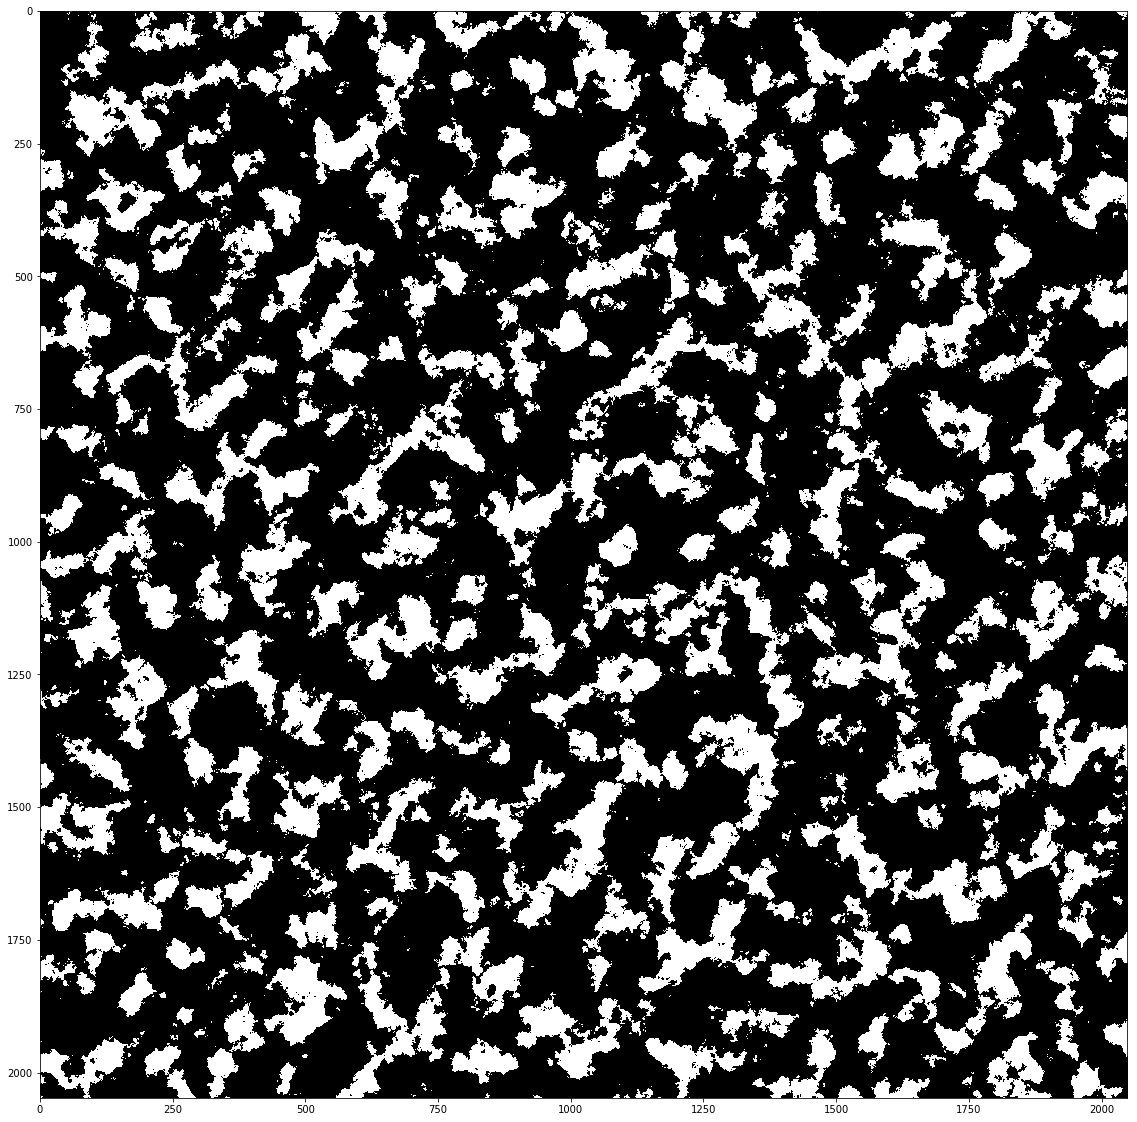

Wall time: 11.8 s


In [26]:
%%time

scale = 128.0
octaves = 16
persistence = 0.6
lacunarity = 1.9
levl = 0.40

colormap = LinearSegmentedColormap(
    'TerrainCmap', {
        'red': (
            (0.00, 0.00, 0.00),
            (levl, 0.00, 1.00),
            (1.00, 1.00, 1.00),
        ),

        'green': (
            (0.00, 0.00, 0.00),
            (levl, 0.00, 1.00),
            (1.00, 1.00, 1.00),
        ),

        'blue': (
            (0.00, 0.00, 0.00),
            (levl, 0.00, 1.00),
            (1.00, 1.00, 1.00),
        ),
    })

print('a')
img = np.zeros((MAP_SIZE, MAP_SIZE), np.float32)
print('b')
for i in range(MAP_SIZE):
    for j in range(MAP_SIZE):
        val = noise.snoise2(i / scale,
                            j / scale,
                            octaves=octaves,
                            persistence=persistence,
                            lacunarity=lacunarity,
                            base=0)
        img[i][j] = ((val + 1) / 2.0)**2
print('c')
plt.imshow(img, cmap=colormap)
print('d')
plt.show()